# Прогнозирование оттока клиентов
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib

Using matplotlib backend: Qt5Agg


# 1. Загрузка и анализ данных
---

## 1.1 Загрузка

In [2]:
PATH_TO_DATA = 'D:\Задача 1\Данные для задачи - Ренессанс.txt'
data = pd.read_csv(PATH_TO_DATA, header=0, sep=';', quotechar='"')
pd.set_option('precision', 2)
data.head()

,DATA_TYPE,POLICY_ID,POLICY_BEGIN_MONTH,POLICY_END_MONTH,POLICY_IS_RENEWED,POLICY_SALES_CHANNEL,POLICY_SALES_CHANNEL_GROUP,POLICY_BRANCH,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,...,POLICY_PRV_CLM_GLT_N,CLIENT_HAS_DAGO,CLIENT_HAS_OSAGO,POLICY_COURT_SIGN,CLAIM_AVG_ACC_ST_PRD,POLICY_HAS_COMPLAINTS,POLICY_YEARS_RENEWED_N,POLICY_DEDUCT_VALUE,CLIENT_REGISTRATION_REGION,POLICY_PRICE_CHANGE
0,TRAIN,1,1,1,1,39,1,Москва,51,12,...,N,1,0,0,0.0,0,0,0.0,Тульская,-1.00
1,TRAIN,2,1,1,1,50,5,Москва,35,7,...,0,1,1,0,0.0,0,4,0.0,Москва,-0.05
2,TRAIN,3,1,1,1,52,6,Москва,41,6,...,1L,0,0,0,0.0,0,1,12518.0,Московская,-0.07
3,TRAIN,4,1,1,1,50,5,Москва,36,12,...,0,1,1,0,0.0,0,6,15000.0,Москва,0.05
4,TRAIN,5,1,1,0,52,6,Санкт-Петербург,42,5,...,N,0,0,0,0.0,0,0,50000.0,Ленинградская,0.17


In [3]:
data.shape

(96605, 30)

Проведем проверку на дубликаты строк.

In [4]:
data[data.duplicated()]

,DATA_TYPE,POLICY_ID,POLICY_BEGIN_MONTH,POLICY_END_MONTH,POLICY_IS_RENEWED,POLICY_SALES_CHANNEL,POLICY_SALES_CHANNEL_GROUP,POLICY_BRANCH,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,...,POLICY_PRV_CLM_GLT_N,CLIENT_HAS_DAGO,CLIENT_HAS_OSAGO,POLICY_COURT_SIGN,CLAIM_AVG_ACC_ST_PRD,POLICY_HAS_COMPLAINTS,POLICY_YEARS_RENEWED_N,POLICY_DEDUCT_VALUE,CLIENT_REGISTRATION_REGION,POLICY_PRICE_CHANGE


Видно, что дубликовто не обнаружено.

## 1.2 Проверка на пропуски

In [5]:
data.isna().any()

DATA_TYPE                        False
POLICY_ID                        False
POLICY_BEGIN_MONTH               False
POLICY_END_MONTH                 False
POLICY_IS_RENEWED                False
POLICY_SALES_CHANNEL             False
POLICY_SALES_CHANNEL_GROUP       False
POLICY_BRANCH                    False
POLICY_MIN_AGE                   False
POLICY_MIN_DRIVING_EXPERIENCE    False
VEHICLE_MAKE                     False
VEHICLE_MODEL                    False
VEHICLE_ENGINE_POWER             False
VEHICLE_IN_CREDIT                False
VEHICLE_SUM_INSURED              False
POLICY_INTERMEDIARY              False
INSURER_GENDER                   False
POLICY_CLM_N                     False
POLICY_CLM_GLT_N                 False
POLICY_PRV_CLM_N                 False
POLICY_PRV_CLM_GLT_N             False
CLIENT_HAS_DAGO                  False
CLIENT_HAS_OSAGO                 False
POLICY_COURT_SIGN                False
CLAIM_AVG_ACC_ST_PRD             False
POLICY_HAS_COMPLAINTS    

Пропусков данных не обнаружено

## 1.3 Выделение признаков

Выделим в отдельные списки категориальные и числовые признаки для того, чтобы в дальнейшем их было легко трансформировать для разных моделей обучения

In [6]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']
print ('Категориальные:')
print (categorical_columns)
print ('Вещестыенные:')
print (numerical_columns)

Категориальные:
['DATA_TYPE', 'POLICY_BRANCH', 'VEHICLE_MAKE', 'VEHICLE_MODEL', 'POLICY_INTERMEDIARY', 'INSURER_GENDER', 'POLICY_CLM_N', 'POLICY_CLM_GLT_N', 'POLICY_PRV_CLM_N', 'POLICY_PRV_CLM_GLT_N', 'POLICY_YEARS_RENEWED_N', 'CLIENT_REGISTRATION_REGION']
Вещестыенные:
['POLICY_ID', 'POLICY_BEGIN_MONTH', 'POLICY_END_MONTH', 'POLICY_IS_RENEWED', 'POLICY_SALES_CHANNEL', 'POLICY_SALES_CHANNEL_GROUP', 'POLICY_MIN_AGE', 'POLICY_MIN_DRIVING_EXPERIENCE', 'VEHICLE_ENGINE_POWER', 'VEHICLE_IN_CREDIT', 'VEHICLE_SUM_INSURED', 'CLIENT_HAS_DAGO', 'CLIENT_HAS_OSAGO', 'POLICY_COURT_SIGN', 'CLAIM_AVG_ACC_ST_PRD', 'POLICY_HAS_COMPLAINTS', 'POLICY_DEDUCT_VALUE', 'POLICY_PRICE_CHANGE']


Проведем исследование категориальных признаков.

In [7]:
data[categorical_columns].describe()

,DATA_TYPE,POLICY_BRANCH,VEHICLE_MAKE,VEHICLE_MODEL,POLICY_INTERMEDIARY,INSURER_GENDER,POLICY_CLM_N,POLICY_CLM_GLT_N,POLICY_PRV_CLM_N,POLICY_PRV_CLM_GLT_N,POLICY_YEARS_RENEWED_N,CLIENT_REGISTRATION_REGION
count,96605,96605,96605,96605,96605,96605,96605,96605,96605,96605,96605,96605
unique,2,2,83,549,1406,2,7,7,7,7,12,85
top,TRAIN,Москва,Kia,RAV4,N,M,0,0,0,0,0,Санкт-Петербург
freq,77407,50697,11050,4186,20630,61044,68111,72295,44587,48153,33249,38854


In [8]:
for c in categorical_columns:
    print (c, data[c].unique());

DATA_TYPE ['TRAIN' 'TEST ']
POLICY_BRANCH ['Москва' 'Санкт-Петербург']
VEHICLE_MAKE ['Land Rover' 'Opel' 'Kia' 'Citroen' 'Renault' 'Suzuki' 'Hyundai' 'BMW'
 'Skoda' 'Volkswagen' 'Ssang Yong' 'Toyota' 'Ford' 'Fiat' 'Honda' 'Mazda'
 'Mitsubishi' 'Peugeot' 'Nissan' 'ГАЗ' 'Dodge' 'Lifan' 'Audi' 'УАЗ'
 'Volvo' 'Porsche' 'Subaru' 'ВАЗ' 'Chevrolet' 'Daewoo' 'Lada'
 'Mercedes-Benz' 'Lexus' 'Другая марка (Иностранного производства)' 'Seat'
 'Jeep' 'Infiniti' 'Acura' 'Mini'
 'Другая марка (Отечественного производства)' 'Geely' 'Great Wall'
 'Datsun' 'Chrysler' 'Chery' 'Cadillac' 'Jaguar' 'Smart' 'Tagaz' 'Vortex'
 'Brilliance' 'КАМАЗ' 'Saab' 'Scania' 'Wielton' 'Faw' 'Hummer' 'Daihatsu'
 'Changan' 'MAN' 'DAF' 'BYD' 'Lincoln' 'Alfa Romeo' 'Bogdan' 'Maserati'
 'Haima' 'Scion' 'Jcb' 'Купава' 'Rolls-Royce' 'Rover' 'ПАЗ' 'Bentley'
 'Ferrari' 'ИПВ' 'Iveco' 'Kogel' 'ИЖ' 'Krone' 'Hafei' '<Пусто>' 'МАЗ']
VEHICLE_MODEL ['Discovery' 'Zafira' 'Soul' 'C-Crosser' 'Logan' 'Grand Vitara' 'Sorento'
 'Santa Fe' 'X3

Из вывода выше видно, что есть поля типа N, n/d, <Пусто>. Скорее всего это заполненные пустые поля типа (None). Оставим эти значения в данных, так как за нас их уже кто-то заполнил. Иначе, нам бы пришлось заполнять эти значения модой.

#### Выделяем бинарные признаки

In [9]:
data_describe = data.describe(include=[object])
binary_columns = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
for i in binary_columns:
    if i in categorical_columns:
        categorical_columns.remove(i)
binary_columns += ['VEHICLE_IN_CREDIT','CLIENT_HAS_DAGO','CLIENT_HAS_OSAGO','POLICY_COURT_SIGN','POLICY_HAS_COMPLAINTS']
for i in binary_columns:
    if i in numerical_columns:
        numerical_columns.remove(i) #удаляем дубликаты из списка
print('Бинарные признаки: ', binary_columns)

Бинарные признаки:  ['DATA_TYPE', 'POLICY_BRANCH', 'INSURER_GENDER', 'VEHICLE_IN_CREDIT', 'CLIENT_HAS_DAGO', 'CLIENT_HAS_OSAGO', 'POLICY_COURT_SIGN', 'POLICY_HAS_COMPLAINTS']


#### Выделяем в отдельный лист числовые признаки похожие на категориальные

In [10]:
num_categorical_columns = ['POLICY_SALES_CHANNEL_GROUP', 'POLICY_SALES_CHANNEL', 'POLICY_END_MONTH', 'POLICY_BEGIN_MONTH']
for i in num_categorical_columns:
    numerical_columns.remove(i)

## 1.4 Чистка данных

Есть колонки, которые смысла не несут, это DATA_TYPE - тип выборки и POLICY_ID - ID полиса. Также удалим из набора столбец POLICY_IS_RENEWED - прогнозируемый параметр

In [11]:
numerical_columns.remove('POLICY_IS_RENEWED')
binary_columns.remove('DATA_TYPE')
numerical_columns.remove('POLICY_ID')

### Поиск выбросов

In [12]:
data[numerical_columns].describe()

,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,VEHICLE_ENGINE_POWER,VEHICLE_SUM_INSURED,CLAIM_AVG_ACC_ST_PRD,POLICY_DEDUCT_VALUE,POLICY_PRICE_CHANGE
count,96605.00,96605.00,96605.00,9.66e+04,96605.00,96605.00,96605.00
mean,42.58,34.91,154.20,9.81e+05,3.88,5974.13,-0.03
std,10.69,199.93,54.12,6.90e+05,17.64,10418.70,0.86
min,18.00,0.00,0.00,0.00e+00,0.00,0.00,-1.00
25%,34.00,8.00,123.00,5.58e+05,0.00,0.00,-0.17
50%,41.00,14.00,146.00,8.09e+05,0.00,0.00,0.00
75%,50.00,19.00,171.00,1.16e+06,0.00,10000.00,0.05
max,86.00,2015.00,2000.00,9.45e+06,737.00,120873.00,60.02


Видно сильные выбросы в столбце POLICY_MIN_DRIVING_EXPERIENCE: макс.знач. = 2015.00 при mean = 34.91 и квантиле 0.75 = 19.00 Проверим сколько выбросов в этом столбце.

In [13]:
print('Кол-во выбросов в POLICY_MIN_DRIVING_EXPERIENCE: ',
      data[data['POLICY_MIN_DRIVING_EXPERIENCE']>100]['POLICY_MIN_DRIVING_EXPERIENCE'].count())

Кол-во выбросов в POLICY_MIN_DRIVING_EXPERIENCE:  992


Видно достаточно большое кол-во выбросов. От них необходимо избавиться. По виду этих выбросов видно, что они соответсвуют не признаку "Минимальный стаж вождения лиц допущенных к управлению по полису", а скорее дате выдачи прав. Поэтому приведем эти выбросы к нужному нам формату путем вычета данных из текущего года.

In [14]:
data['POLICY_MIN_DRIVING_EXPERIENCE'] = np.where(data['POLICY_MIN_DRIVING_EXPERIENCE'] > 100, 
                                                 2019 - data['POLICY_MIN_DRIVING_EXPERIENCE'], 
                                                 data['POLICY_MIN_DRIVING_EXPERIENCE'])
print('Кол-во выбросов в POLICY_MIN_DRIVING_EXPERIENCE: ',
      data[data['POLICY_MIN_DRIVING_EXPERIENCE']>100]['POLICY_MIN_DRIVING_EXPERIENCE'].count())

Кол-во выбросов в POLICY_MIN_DRIVING_EXPERIENCE:  0


Также наблюдаются выбросы у признака VEHICLE_ENGINE_POWER. Удалим их из обучающего набора.

In [15]:
del_indx = data[(data['VEHICLE_ENGINE_POWER'] > 1000) & (data['DATA_TYPE']=='TRAIN')].index
print('Кол-во выбросов в VEHICLE_ENGINE_POWER: ',
      len(del_indx))

Кол-во выбросов в VEHICLE_ENGINE_POWER:  2


In [16]:
#data = data.drop(list(del_indx), axis=0)

In [17]:
del_indx = data[(data['VEHICLE_ENGINE_POWER'] > 1000) & (data['DATA_TYPE']=='TRAIN')].index
print('Кол-во выбросов в VEHICLE_ENGINE_POWER: ',
      len(del_indx))

Кол-во выбросов в VEHICLE_ENGINE_POWER:  2


Проведем исследование признаков на линейную зависимость. Для этого выведем матрицу корреляции.

In [18]:
corr_matrix = data[numerical_columns+['POLICY_IS_RENEWED']].corr()
corr_matrix

,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,VEHICLE_ENGINE_POWER,VEHICLE_SUM_INSURED,CLAIM_AVG_ACC_ST_PRD,POLICY_DEDUCT_VALUE,POLICY_PRICE_CHANGE,POLICY_IS_RENEWED
POLICY_MIN_AGE,1.00,6.31e-01,-6.29e-02,-4.82e-02,-2.76e-02,-1.57e-01,-1.99e-02,2.54e-02
POLICY_MIN_DRIVING_EXPERIENCE,0.63,1.00e+00,5.43e-02,3.39e-02,-3.12e-02,-1.03e-01,-2.10e-03,1.27e-02
VEHICLE_ENGINE_POWER,-0.06,5.43e-02,1.00e+00,7.80e-01,3.38e-05,-3.53e-02,4.29e-02,-5.53e-03
VEHICLE_SUM_INSURED,-0.05,3.39e-02,7.80e-01,1.00e+00,5.66e-03,-6.11e-02,1.75e-02,-3.00e-02
CLAIM_AVG_ACC_ST_PRD,-0.03,-3.12e-02,3.38e-05,5.66e-03,1.00e+00,-4.98e-02,1.36e-02,-3.50e-02
POLICY_DEDUCT_VALUE,-0.16,-1.03e-01,-3.53e-02,-6.11e-02,-4.98e-02,1.00e+00,-4.07e-02,-1.15e-03
POLICY_PRICE_CHANGE,-0.02,-2.10e-03,4.29e-02,1.75e-02,1.36e-02,-4.07e-02,1.00e+00,-5.40e-02
POLICY_IS_RENEWED,0.03,1.27e-02,-5.53e-03,-3.00e-02,-3.50e-02,-1.15e-03,-5.40e-02,1.00e+00


In [19]:
str_max = np.amax(corr_matrix - np.eye(len(corr_matrix)))
print('Максимальные значения коэф. кор.:\n', str_max)

Максимальные значения коэф. кор.:
 POLICY_MIN_AGE                   0.63
POLICY_MIN_DRIVING_EXPERIENCE    0.63
VEHICLE_ENGINE_POWER             0.78
VEHICLE_SUM_INSURED              0.78
CLAIM_AVG_ACC_ST_PRD             0.01
POLICY_DEDUCT_VALUE              0.00
POLICY_PRICE_CHANGE              0.04
POLICY_IS_RENEWED                0.03
dtype: float64


По данным видно, что POLICY_IS_RENEWED - прогнозируемый параметр нискем не коррелирует. 
    

Из всех данных выделяются признаки 'VEHICLE_ENGINE_POWER' и 'VEHICLE_SUM_INSURED' c наибольшей. И это соответсвует логике, чем больше Мощность двигателя ТС, тем выше Страховая сумма по полису. Посмотрим их распределение относительно друг друга.

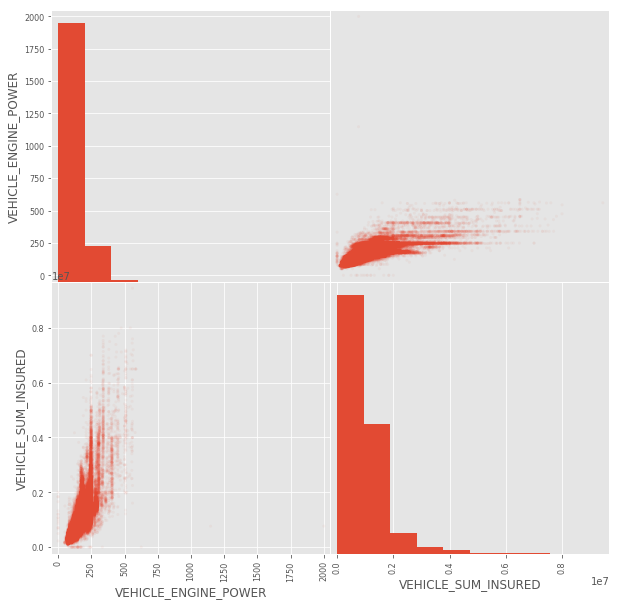

In [20]:
from pandas.plotting import scatter_matrix
scatter_matrix(data[['VEHICLE_ENGINE_POWER','VEHICLE_SUM_INSURED']], alpha=0.05, figsize=(10, 10));

Построим диаграмму рассеяния для этой пары признаков.

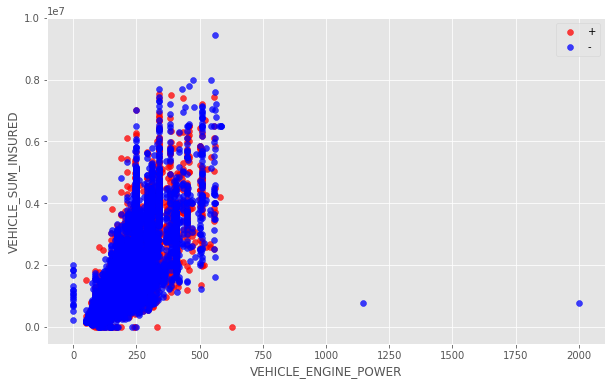

In [21]:
col1 = 'VEHICLE_ENGINE_POWER'
col2 = 'VEHICLE_SUM_INSURED'

plt.figure(figsize=(10, 6))

plt.scatter(data[col1][data['POLICY_IS_RENEWED'] == 1],
            data[col2][data['POLICY_IS_RENEWED'] == 1],
            alpha=0.75,
            color='red',
            label='+')

plt.scatter(data[col1][data['POLICY_IS_RENEWED'] == 0],
            data[col2][data['POLICY_IS_RENEWED'] == 0],
            alpha=0.75,
            color='blue',
            label='-')

plt.xlabel(col1)
plt.ylabel(col2)
plt.legend(loc='best');

Из диаграммы, в частности, видно, что признаки не являются существенным. Иными словами, визуально наблюдается хорошая корреляция между. 

Проведем исследование СКО числовых признаков.

In [22]:
data[numerical_columns+binary_columns].std().sort_values()

POLICY_COURT_SIGN                     0.03
POLICY_HAS_COMPLAINTS                 0.09
CLIENT_HAS_DAGO                       0.45
VEHICLE_IN_CREDIT                     0.47
CLIENT_HAS_OSAGO                      0.50
POLICY_PRICE_CHANGE                   0.86
POLICY_MIN_DRIVING_EXPERIENCE         9.27
POLICY_MIN_AGE                       10.69
CLAIM_AVG_ACC_ST_PRD                 17.64
VEHICLE_ENGINE_POWER                 54.12
POLICY_DEDUCT_VALUE               10418.70
VEHICLE_SUM_INSURED              690091.88
dtype: float64

Из таблицы выше видно, что у столбцов POLICY_HAS_COMPLAINTS и POLICY_COURT_SIGN показатель std (СКО) близок к нулю, т.е. эти признаки слабо изменчивы и скорее всего у них наблюдается "перекос" значений. Это тоже признаки-кандидаты на удаление. Cделаем дополнительную проверку.

D:\Programms\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017CD7D387B8>,
      dtype=object)

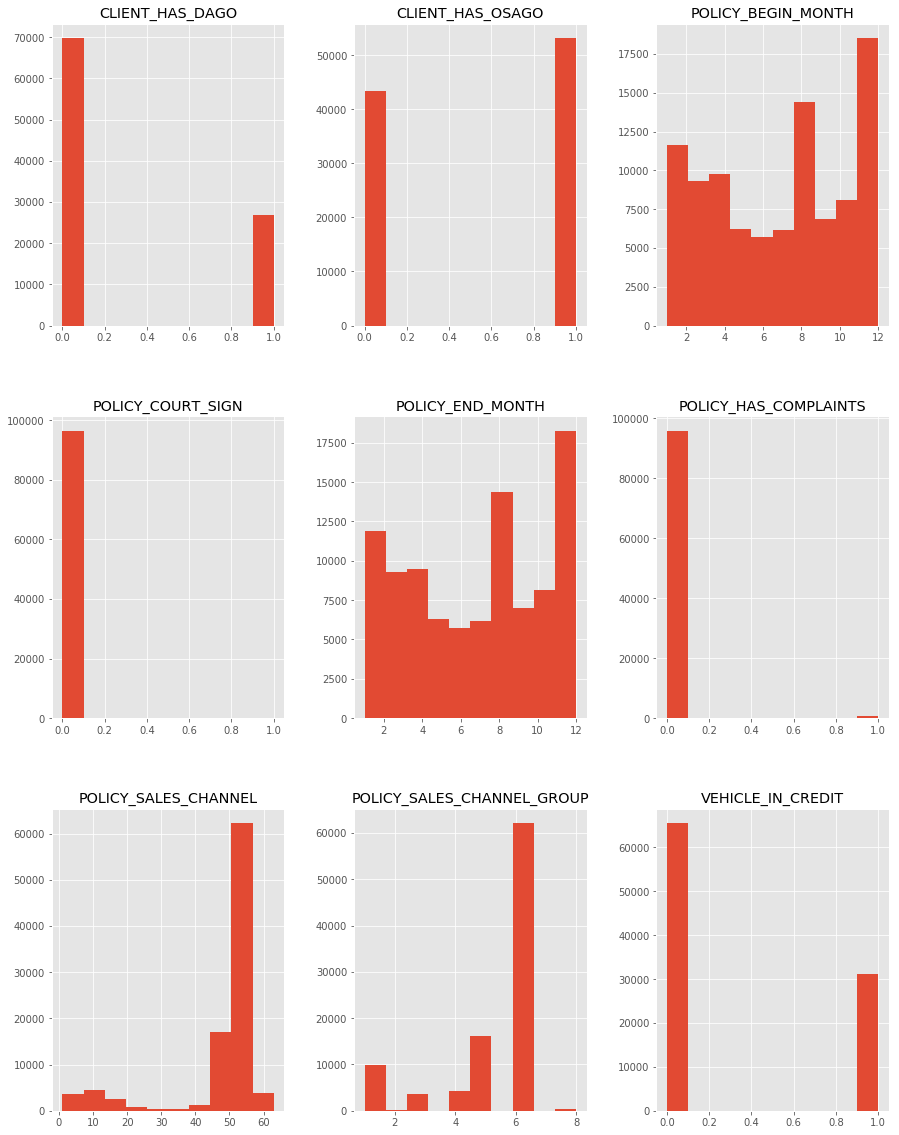

In [23]:
fig = plt.figure(figsize =(15,20))
ax = fig.gca()
data[categorical_columns+binary_columns+num_categorical_columns].hist(ax = ax)

'POLICY_HAS_COMPLAINTS' и 'POLICY_COURT_SIGN' не коррелируют с прогнозным признаком и наблюдается сильный перекос, поэтому сильное влияние на результат не будет.

In [26]:
for i in ['POLICY_HAS_COMPLAINTS','POLICY_COURT_SIGN']:
    binary_columns.remove(i)

## 1.5 Подготовка данных для моделирования

In [27]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
#числовые
std_sc = StandardScaler()
data[numerical_columns] = data[numerical_columns].astype(float)
data[numerical_columns] = std_sc.fit_transform(data[numerical_columns])
#категор для деревьев
label_encoder_dict = {}
for i in categorical_columns+binary_columns:
    label_encoder_dict[i] = LabelEncoder()
    data[i] = label_encoder_dict[i].fit_transform(data[i])
#категор для лог регрессии
oh_en = OneHotEncoder(sparse = False)
oh_clms = oh_en.fit_transform(data[categorical_columns+num_categorical_columns])

D:\Programms\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


## 1.5 Разделение данных на тренеровочную и тестовую части

In [28]:
train_index = data[data['DATA_TYPE']=='TRAIN'].index
test_index = data[data['DATA_TYPE']=='TEST '].index

Для удобства отдельно рассмотрим столбцы, соответствующие входным признакам (это будет матрица X), а отдельно – выделенный признак (вектор Y):

In [29]:
X_train = np.concatenate([data.loc[train_index, numerical_columns+binary_columns],
                oh_clms[train_index]], axis = 1)
X_test = np.concatenate([data.loc[test_index, numerical_columns+binary_columns],
                oh_clms[test_index]], axis = 1)
Y_train = data['POLICY_IS_RENEWED'][train_index]
Y_test = data['POLICY_IS_RENEWED'][test_index]

Выделим из обучающей выборки часть данных для валидации модели

In [30]:
from sklearn.model_selection import train_test_split
x_train_set, x_test_set, y_train_set, y_test_set = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 11)

# 2. Прогнозирование
---

Для начала исследуем распределение классов в тренировочной выборке на наличие перекоса данных.

Разделение классов в тренеровочной выборке:  0.6249563992920537 0.3750436007079463


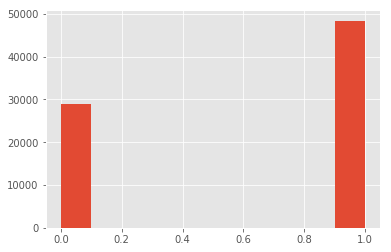

In [44]:
data['POLICY_IS_RENEWED'][train_index].hist()
c = len(train_index)
s = sum(data['POLICY_IS_RENEWED'][train_index])
print('Разделение классов в тренеровочной выборке: ', s/c, 1-s/c)

Видно из гистограммы, что есть перекос, поэтому для всех моделей выберем метрику качества  F1, потому что она учитывет перекос данных.

## 2.1 Логистическая регрессия

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer, accuracy_score

In [46]:
grid={
    "C":[0.003, 0.001, 0.01], 
    "penalty":["l1","l2"]}
f1_scorer = make_scorer(f1_score)

Запускаем поиск оптимальных параметров для модели.

In [47]:
lg_clf = LogisticRegression(random_state=1777)
skf_lg = StratifiedKFold(n_splits=5, shuffle=True, random_state=1777)
logreg_cv=GridSearchCV(lg_clf,grid, n_jobs=2, cv=skf_lg, verbose=1000, scoring=f1_scorer)
logreg_cv.fit(x_train_set,y_train_set)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
Memmapping (shape=(54184, 2270), dtype=float64) to new file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_15196_9428351285\15196-3028412097704-70476658b65d4b9599eb82fddfe65079.pkl
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43347,), dtype=int32).
Pickling array (shape=(10837,), dtype=int32).
Memmapping (shape=(54184, 2270), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_15196_9428351285\15196-3028412097704-70476658b65d4b9599eb82fddfe65079.pkl
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43347,), dtype=int32).
Pickling array (shape=(10837,), dtype=int32).
Memmapping (shape=(54

[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  1.1min
Memmapping (shape=(54184, 2270), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_15196_9428351285\15196-3028412097704-70476658b65d4b9599eb82fddfe65079.pkl
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43347,), dtype=int32).
Pickling array (shape=(10837,), dtype=int32).
[Parallel(n_jobs=2)]: Done  17 tasks      | elapsed:  1.1min
Memmapping (shape=(54184, 2270), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_15196_9428351285\15196-3028412097704-70476658b65d4b9599eb82fddfe65079.pkl
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43348,), dtype=int32).
Pickling array (shape=(10836,), dtype=int32).
[Parallel(n_jobs=2)]: Done  18 tas

D:\Programms\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1777, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1777, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'C': [0.003, 0.001, 0.01], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score), verbose=1000)

In [49]:
logreg_cv.best_params_

{'C': 0.001, 'penalty': 'l2'}

In [50]:
lg_clf = LogisticRegression(random_state=1777, 
                            C=0.001, 
                            penalty='l2')
lg_clf.fit(x_train_set,y_train_set)

D:\Programms\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1777, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [51]:
y_train_predict = lg_clf.predict(x_train_set)
y_train_predict_proba = lg_clf.predict_proba(x_train_set)[:,1] #все метки класса 1
y_test_predict = lg_clf.predict(x_test_set)
y_test_predict_proba = lg_clf.predict_proba(x_test_set)[:,1] #все метки класса 1
print('f1 мера на обучающей выборке: ', f1_score(y_train_set, y_train_predict.round()))
print('f1 мера на тестовой выборке: ', f1_score(y_test_set, y_test_predict.round()) )

f1 мера на обучающей выборке:  0.7769882143210854
f1 мера на тестовой выборке:  0.7749249942303255


## 2.2 Случайный лес

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, make_scorer, accuracy_score

In [96]:
param_grid = { 
    'n_estimators': [50, 100, 200],
    'max_depth' : [12, 14, 16],
    'min_samples_split' : [2, 4, 8],
    'min_samples_leaf' : [1, 3, 5],
    'max_features': ['sqrt']
}
f1_scorer = make_scorer(f1_score)

X_train_tree = data.loc[train_index, numerical_columns+categorical_columns+binary_columns+num_categorical_columns]
X_test_tree = data.loc[test_index, numerical_columns+categorical_columns+binary_columns+num_categorical_columns]
test_size = 0.3
x_train_tree_set, x_test_tree_set, y_train_set, y_test_set = train_test_split(X_train_tree, 
                                                                              Y_train, 
                                                                              test_size = test_size, 
                                                                              random_state = 11)

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rfc = RandomForestClassifier(oob_score = True) 

CV_rfc = GridSearchCV(estimator=rfc,
                      param_grid=param_grid, 
                      cv=skf, n
                      _jobs=6, 
                      verbose=1000,
                      random_state=11,
                     scoring=f1_scorer)
CV_rfc.fit(x_train_tree_set,y_train_set)

In [ ]:
print(CV_rfc.best_params_)

Оптимальные параметры для модели получились следующие: {'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}

In [35]:
rfc = RandomForestClassifier(max_depth = 16, 
                             max_features = 'sqrt', 
                             min_samples_leaf = 3, 
                             min_samples_split = 2, 
                             n_estimators = 300, 
                             oob_score = True, 
                             n_jobs=-1,
                             random_state = 11)
rfc.fit(x_train_tree_set,y_train_set)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=True, random_state=11, verbose=0, warm_start=False)

In [56]:
y_train_predict = rfc.predict(x_train_tree_set)
y_train_predict_proba = rfc.predict_proba(x_train_tree_set)[:,1] #все метки класса 1
y_test_predict = rfc.predict(x_test_tree_set)
y_test_predict_proba = rfc.predict_proba(x_test_tree_set)[:,1] #все метки класса 1
print('f1 мера на обучающей выборке: ', f1_score(y_train_set, y_train_predict.round()))
print('f1 мера на тестовой выборке: ', f1_score(y_test_set, y_test_predict.round()) )

f1 мера на обучающей выборке:  0.882231707154919
f1 мера на тестовой выборке:  0.7991127047312285


Результат лучше логистической регрессии. Попытаемся еще улучшить качество нашей модели.

# 3. "Тюннинг" модели
---

Случайным образом сгенерируем признаки

In [87]:
def preprocess_raw_data(raw_data):
    import numpy as np
    raw_data['f_1'] = (raw_data['POLICY_MIN_AGE'] * raw_data['POLICY_MIN_DRIVING_EXPERIENCE'])  / (raw_data['POLICY_DEDUCT_VALUE'] + 1.0)
    raw_data['f_2'] = (raw_data['POLICY_MIN_DRIVING_EXPERIENCE'] * (1- raw_data['POLICY_DEDUCT_VALUE']) )  / (raw_data['POLICY_MIN_DRIVING_EXPERIENCE'] + 1.0)
    raw_data['f_3']  =  raw_data['VEHICLE_SUM_INSURED']                      / (raw_data['POLICY_PRICE_CHANGE'] + 1.0)
    raw_data['f_4'] = raw_data['POLICY_DEDUCT_VALUE'] / raw_data['POLICY_MIN_AGE']
    raw_data['f_5'] = raw_data['POLICY_MIN_DRIVING_EXPERIENCE']      / raw_data['POLICY_PRICE_CHANGE']
    raw_data['f_6'] = raw_data['POLICY_MIN_AGE'] / raw_data['POLICY_MIN_DRIVING_EXPERIENCE']
    raw_data['f_7'] = raw_data['POLICY_DEDUCT_VALUE'] / (1 + raw_data['POLICY_MIN_AGE'])
    raw_data['f_8'] = raw_data['POLICY_MIN_AGE'] / (1 + raw_data['POLICY_DEDUCT_VALUE'])
    raw_data['f_9'] = raw_data['POLICY_MIN_DRIVING_EXPERIENCE'] / (1 + raw_data['POLICY_DEDUCT_VALUE'])
    raw_data['f_10'] = raw_data['POLICY_MIN_AGE'] / raw_data['VEHICLE_SUM_INSURED']
    raw_data['f_11'] = raw_data['VEHICLE_SUM_INSURED'] / raw_data['POLICY_MIN_AGE']
    raw_data['f_12'] = raw_data['POLICY_MIN_DRIVING_EXPERIENCE'] * raw_data['VEHICLE_SUM_INSURED']/(raw_data['CLAIM_AVG_ACC_ST_PRD'] )
    raw_data['f_13'] = raw_data['POLICY_MIN_AGE'] * raw_data['POLICY_PRICE_CHANGE']
    raw_data['f_14'] = raw_data['POLICY_DEDUCT_VALUE'] * raw_data['CLAIM_AVG_ACC_ST_PRD']
    raw_data['f_15'] = raw_data['POLICY_MIN_AGE'] / (raw_data['VEHICLE_SUM_INSURED'] + 1.0)
    raw_data['f_16']  =  raw_data['POLICY_MIN_DRIVING_EXPERIENCE'] * raw_data['POLICY_MIN_AGE']
    raw_data['f_17'] = raw_data['CLAIM_AVG_ACC_ST_PRD'] / (raw_data['POLICY_DEDUCT_VALUE'] + 1.0)
    raw_data['f_18'] = raw_data['POLICY_PRICE_CHANGE'] / (raw_data['POLICY_PRICE_CHANGE'] + 1.0)
    raw_data['f_19']  =  raw_data['POLICY_PRICE_CHANGE'] / raw_data['VEHICLE_SUM_INSURED']
    raw_data['f_20'] = raw_data['POLICY_MIN_AGE'] * raw_data['CLAIM_AVG_ACC_ST_PRD']
    raw_data['f_21'] = raw_data['POLICY_MIN_DRIVING_EXPERIENCE'] * raw_data['CLAIM_AVG_ACC_ST_PRD']
    raw_data['f_22'] = raw_data['CLAIM_AVG_ACC_ST_PRD'] * raw_data['POLICY_DEDUCT_VALUE']
    raw_data['f_23']  =  raw_data['VEHICLE_SUM_INSURED'] / raw_data['POLICY_PRICE_CHANGE']
    raw_data['f_24']  =  raw_data['CLAIM_AVG_ACC_ST_PRD'] / raw_data['POLICY_MIN_AGE']
    raw_data['f_25']  =  raw_data['POLICY_PRICE_CHANGE'] / (raw_data['VEHICLE_SUM_INSURED'] + 1.0)
    raw_data['f_26'] = raw_data['POLICY_MIN_DRIVING_EXPERIENCE'] * raw_data['CLAIM_AVG_ACC_ST_PRD']
    raw_data['f_27']  =  raw_data['POLICY_MIN_AGE'] / (1.0 + np.e ** (raw_data['POLICY_MIN_DRIVING_EXPERIENCE']))
    raw_data['f_28'] = raw_data['CLAIM_AVG_ACC_ST_PRD'] * raw_data['VEHICLE_SUM_INSURED']
    raw_data['f_29'] = (raw_data['VEHICLE_SUM_INSURED'] * raw_data['CLAIM_AVG_ACC_ST_PRD'])  / (raw_data['VEHICLE_SUM_INSURED'] + 1.0)
    raw_data['f_30'] = (raw_data['CLAIM_AVG_ACC_ST_PRD'] * (1- raw_data['VEHICLE_SUM_INSURED']) )  / (raw_data['CLAIM_AVG_ACC_ST_PRD'] + 1.0)
    raw_data['f_31']  =  raw_data['POLICY_PRICE_CHANGE'] / (raw_data['POLICY_PRICE_CHANGE'] + 1.0)
    raw_data['f_32']  =  raw_data['POLICY_PRICE_CHANGE'] / (raw_data['CLAIM_AVG_ACC_ST_PRD'] + 1.0)
    raw_data['f_33'] = raw_data['POLICY_MIN_DRIVING_EXPERIENCE'] / raw_data['POLICY_DEDUCT_VALUE']
    raw_data['f_34'] = raw_data['POLICY_PRICE_CHANGE']      / raw_data['POLICY_MIN_AGE']
    
    return raw_data

## 3.1 Добавление новых сгенерированных признаков

In [98]:
X_train_tree = preprocess_raw_data(X_train_tree)
X_test_tree = preprocess_raw_data(X_test_tree)

In [118]:
X_train_tree.shape

(77407, 59)

## 3.3 Новое обучение и прогноз

Найдем оптимальные параметры для модели уже сновыми данными.

In [100]:
test_size = 0.3
x_train_tree_set, x_test_tree_set, y_train_set, y_test_set = train_test_split(X_train_tree, 
                                                                              Y_train, 
                                                                              test_size = test_size, 
                                                                              random_state = 1707)

In [103]:
param_grid = { 
    'n_estimators': [50, 100, 200],
    'max_depth' : [12, 14, 16],
    'min_samples_split' : [2, 4, 8],
    'min_samples_leaf' : [1, 3, 5],
    'max_features': ['sqrt']
}
f1_scorer = make_scorer(f1_score)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1707)
rfc = RandomForestClassifier(oob_score = True) 

CV_rfc = GridSearchCV(estimator=rfc,
                      param_grid=param_grid, 
                      cv=skf, n_jobs=6, 
                      verbose=1000,
                     scoring=f1_scorer)
CV_rfc.fit(x_train_tree_set,y_train_set)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to new file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to new file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to new file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=in

[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   19.1s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   19.1s
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling 

[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:   47.3s
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done  18 tasks      | elapsed:  1.7min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done  26 tasks      | elapsed:  2.4min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done  34 tasks      | elapsed:  3.0min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done  42 tasks      | elapsed:  4.0min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done  50 tasks      | elapsed:  4.4min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done  58 tasks      | elapsed:  5.3min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done  66 tasks      | elapsed:  6.0min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done  74 tasks      | elapsed:  6.7min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done  82 tasks      | elapsed:  7.3min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done  90 tasks      | elapsed:  8.1min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done  99 tasks      | elapsed:  8.7min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 107 tasks      | elapsed:  9.7min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 115 tasks      | elapsed: 10.1min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 123 tasks      | elapsed: 11.1min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 131 tasks      | elapsed: 11.9min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 139 tasks      | elapsed: 12.6min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 147 tasks      | elapsed: 13.7min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 155 tasks      | elapsed: 14.3min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 163 tasks      | elapsed: 15.4min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 171 tasks      | elapsed: 16.2min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 179 tasks      | elapsed: 17.0min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 187 tasks      | elapsed: 17.7min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 195 tasks      | elapsed: 18.6min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 203 tasks      | elapsed: 19.3min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 212 tasks      | elapsed: 20.2min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 220 tasks      | elapsed: 20.9min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 228 tasks      | elapsed: 21.7min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 236 tasks      | elapsed: 22.6min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 244 tasks      | elapsed: 23.3min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 252 tasks      | elapsed: 24.3min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 260 tasks      | elapsed: 24.8min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 268 tasks      | elapsed: 25.9min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed: 26.7min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 284 tasks      | elapsed: 27.7min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 292 tasks      | elapsed: 28.5min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 300 tasks      | elapsed: 29.5min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 308 tasks      | elapsed: 30.2min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 316 tasks      | elapsed: 31.2min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 324 tasks      | elapsed: 31.9min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 332 tasks      | elapsed: 32.9min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 340 tasks      | elapsed: 33.6min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 348 tasks      | elapsed: 34.6min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 356 tasks      | elapsed: 35.5min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 364 tasks      | elapsed: 36.3min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 372 tasks      | elapsed: 37.4min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 380 tasks      | elapsed: 38.0min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 388 tasks      | elapsed: 39.1min
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(5

[Parallel(n_jobs=6)]: Done 396 out of 405 | elapsed: 39.9min remaining:   54.3s
Pickling array (shape=(59,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(41, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-8fa09c8bb2d44c21ac1064f8b474d25a.pkl
Memmapping (shape=(11, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-f3966c2e41c9411997a8735ef7d7d1bd.pkl
Memmapping (shape=(7, 54184), dtype=int64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-5c770b571ff84870b096ceb179dee614.pkl
Pickling array (shape=(41,), dtype=object).
Pickling array (shape=(11,), dtype=object).
Pickling array (shape=(7,), dtype=object).
Pickling array (shape=(41,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickl

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1707, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=6,
       param_grid={'n_estimators': [50, 100, 200], 'max_depth': [12, 14, 16], 'min_samples_split': [2, 4, 8], 'min_samples_leaf': [1, 3, 5], 'max_features': ['sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score), verbose=1000)

In [104]:
print(CV_rfc.best_params_)

{'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}


In [110]:
rfc = RandomForestClassifier(max_depth = 12, 
                             max_features = 'sqrt', 
                             min_samples_leaf = 3, 
                             min_samples_split = 2, 
                             n_estimators = 200, 
                             oob_score = True, 
                             n_jobs=-1,
                             random_state = 1707)
rfc.fit(x_train_tree_set,y_train_set)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=1707, verbose=0, warm_start=False)

In [111]:
y_train_predict = rfc.predict(x_train_tree_set)
y_train_predict_proba = rfc.predict_proba(x_train_tree_set)[:,1] #все метки класса 1
y_test_predict = rfc.predict(x_test_tree_set)
y_test_predict_proba = rfc.predict_proba(x_test_tree_set)[:,1] #все метки класса 1
print('f1 мера на обучающей выборке: ', f1_score(y_train_set, y_train_predict.round()))
print('f1 мера на тестовой выборке: ', f1_score(y_test_set, y_test_predict.round()) )

f1 мера на обучающей выборке:  0.8489652826832013
f1 мера на тестовой выборке:  0.7994794819029173


Результат немного улучшился. Попробуем "выжать" из данных ещё информации. 

## 3.1 Отбор признаков

Выберем из всего множества признаков те, которые имеют большую значимость для нашей модели.

In [130]:
fs = []
top_feature = []
for i in range(1,35):
    fs.append('f_'+str(i))
for a, b in sorted(zip(rfc.feature_importances_,
                       numerical_columns+categorical_columns+binary_columns+num_categorical_columns+fs),
                  reverse=True)[:30]:
    top_feature.append(b)
    print(a,b, sep='\t\t')

0.07386007310239169		f_18
0.06788233745414204		f_31
0.067166791607767		POLICY_PRICE_CHANGE
0.05809025652730382		f_32
0.0374106379251472		f_25
0.028302932780910034		POLICY_CLM_GLT_N
0.028204787125655793		POLICY_YEARS_RENEWED_N
0.028046876276552477		POLICY_PRV_CLM_N
0.026569003393076746		POLICY_PRV_CLM_GLT_N
0.021952641478882273		f_13
0.020308556698945806		f_23
0.0185209618051741		POLICY_INTERMEDIARY
0.01844870587072058		f_3
0.0172369133218787		f_19
0.01637409259204549		POLICY_CLM_N
0.015348558442889564		f_34
0.015227089114830884		POLICY_SALES_CHANNEL
0.014991263056506741		f_30
0.01463699932291311		CLIENT_REGISTRATION_REGION
0.014574779954232979		VEHICLE_MODEL
0.014212103843499213		VEHICLE_SUM_INSURED
0.01419114905499111		f_29
0.013921875515565355		f_15
0.013877264289760462		f_5
0.013438841588525348		f_28
0.013405818107701037		f_27
0.012963696969027928		VEHICLE_ENGINE_POWER
0.01286790640069891		f_12
0.012308021161146052		POLICY_END_MONTH
0.0122165383045082		f_6


Удалим коррелируемые признаки.

In [142]:
corr_matrix = X_train_tree[top_feature].corr()
str_max = np.amax(corr_matrix - np.eye(len(corr_matrix)))
print('Максимальные значения коэф. кор.:\n', str_max)

Максимальные значения коэф. кор.:
 f_18                          1.00
f_31                          1.00
POLICY_PRICE_CHANGE           0.99
f_32                          0.99
f_25                          0.16
POLICY_CLM_GLT_N              0.94
POLICY_YEARS_RENEWED_N        0.12
POLICY_PRV_CLM_N              0.99
POLICY_PRV_CLM_GLT_N          0.99
f_13                          0.15
f_23                          0.24
POLICY_INTERMEDIARY           0.12
f_3                           0.21
f_19                          0.01
POLICY_CLM_N                  0.94
f_34                          0.15
POLICY_SALES_CHANNEL          0.11
f_30                          0.46
CLIENT_REGISTRATION_REGION    0.05
VEHICLE_MODEL                 0.16
VEHICLE_SUM_INSURED           0.78
f_29                          0.40
f_15                          0.40
f_5                           0.08
f_28                          0.01
f_27                          0.08
VEHICLE_ENGINE_POWER          0.78
f_12                

In [144]:
for i in ['f_31','f_32','POLICY_PRV_CLM_GLT_N','POLICY_CLM_N','VEHICLE_ENGINE_POWER']:
    if i in top_feature:
        top_feature.remove(i)

Сгенеририруем новый обучающий набор признаков.

In [145]:
X_train_tree_topf = X_train_tree[top_feature]
X_test_tree_topf = X_train_tree[top_feature]

In [151]:
X_test_tree_topf.shape

(77407, 25)

И снова проведем поиск оптимальных значений параметров для модели.

In [149]:
test_size = 0.3
x_train_tree_set, x_test_tree_set, y_train_set, y_test_set = train_test_split(X_train_tree_topf, 
                                                                              Y_train, 
                                                                              test_size = test_size, 
                                                                              random_state = 1707)

In [150]:
param_grid = { 
    'n_estimators': [50, 100, 200],
    'max_depth' : [12, 14, 16],
    'min_samples_split' : [2, 4, 8],
    'min_samples_leaf' : [1, 3, 5],
    'max_features': ['sqrt']
}
f1_scorer = make_scorer(f1_score)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1707)
rfc = RandomForestClassifier(oob_score = True) 

CV_rfc = GridSearchCV(estimator=rfc,
                      param_grid=param_grid, 
                      cv=skf, n_jobs=6, 
                      verbose=1000,
                     scoring=f1_scorer)
CV_rfc.fit(x_train_tree_set,y_train_set)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to new file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to new file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).

Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43348,), dtype=int32).
Pickling array (shape=(10836,), dtype=int32).
[Parallel(n_jobs=6)]: Done   4 tasks      | 

[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:   59.4s
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43348,), dtype=int32).
Pickling array (shape=(10836,

[Parallel(n_jobs=6)]: Done  21 tasks      | elapsed:  1.6min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43347,), dtype=int32).
Pickling array (shape=(10837,

[Parallel(n_jobs=6)]: Done  30 tasks      | elapsed:  2.4min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43347,), dtype=int32).
Pickling array (shape=(10837,

Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43348,), dtype=int32).
Pickling array (shape=(10836,), dtype=int32).
[Parallel(n_jobs=6)]: Done  39 tasks      | 

[Parallel(n_jobs=6)]: Done  47 tasks      | elapsed:  3.6min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43348,), dtype=int32).
Pickling array (shape=(10836,

[Parallel(n_jobs=6)]: Done  56 tasks      | elapsed:  4.4min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43347,), dtype=int32).
Pickling array (shape=(10837,

[Parallel(n_jobs=6)]: Done  65 tasks      | elapsed:  4.9min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43347,), dtype=int32).
Pickling array (shape=(10837,

[Parallel(n_jobs=6)]: Done  74 tasks      | elapsed:  5.7min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43346,), dtype=int32).
Pickling array (shape=(10838,

[Parallel(n_jobs=6)]: Done  83 tasks      | elapsed:  6.3min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43348,), dtype=int32).
Pickling array (shape=(10836,

[Parallel(n_jobs=6)]: Done  92 tasks      | elapsed:  7.0min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43348,), dtype=int32).
Pickling array (shape=(10836,

[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:  7.7min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43347,), dtype=int32).
Pickling array (shape=(10837,

[Parallel(n_jobs=6)]: Done 110 tasks      | elapsed:  8.2min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43347,), dtype=int32).
Pickling array (shape=(10837,

[Parallel(n_jobs=6)]: Done 119 tasks      | elapsed:  9.2min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43346,), dtype=int32).
Pickling array (shape=(10838,

[Parallel(n_jobs=6)]: Done 128 tasks      | elapsed:  9.7min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43348,), dtype=int32).
Pickling array (shape=(10836,

[Parallel(n_jobs=6)]: Done 137 tasks      | elapsed: 10.5min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43348,), dtype=int32).
Pickling array (shape=(10836,

[Parallel(n_jobs=6)]: Done 146 tasks      | elapsed: 11.3min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43347,), dtype=int32).
Pickling array (shape=(10837,

[Parallel(n_jobs=6)]: Done 155 tasks      | elapsed: 12.1min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43347,), dtype=int32).
Pickling array (shape=(10837,

[Parallel(n_jobs=6)]: Done 164 tasks      | elapsed: 13.5min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43346,), dtype=int32).
Pickling array (shape=(10838,

[Parallel(n_jobs=6)]: Done 174 tasks      | elapsed: 14.2min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43346,), dtype=int32).
Pickling array (shape=(10838,

[Parallel(n_jobs=6)]: Done 183 tasks      | elapsed: 15.2min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43348,), dtype=int32).
Pickling array (shape=(10836,

[Parallel(n_jobs=6)]: Done 192 tasks      | elapsed: 16.1min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43348,), dtype=int32).
Pickling array (shape=(10836,

[Parallel(n_jobs=6)]: Done 201 tasks      | elapsed: 16.9min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43347,), dtype=int32).
Pickling array (shape=(10837,

[Parallel(n_jobs=6)]: Done 210 tasks      | elapsed: 17.9min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43347,), dtype=int32).
Pickling array (shape=(10837,

[Parallel(n_jobs=6)]: Done 219 tasks      | elapsed: 18.5min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43346,), dtype=int32).
Pickling array (shape=(10838,

[Parallel(n_jobs=6)]: Done 228 tasks      | elapsed: 19.4min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43348,), dtype=int32).
Pickling array (shape=(10836,

[Parallel(n_jobs=6)]: Done 237 tasks      | elapsed: 20.4min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43348,), dtype=int32).
Pickling array (shape=(10836,

[Parallel(n_jobs=6)]: Done 246 tasks      | elapsed: 21.1min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43347,), dtype=int32).
Pickling array (shape=(10837,

[Parallel(n_jobs=6)]: Done 255 tasks      | elapsed: 22.0min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43347,), dtype=int32).
Pickling array (shape=(10837,

[Parallel(n_jobs=6)]: Done 264 tasks      | elapsed: 22.6min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43346,), dtype=int32).
Pickling array (shape=(10838,

[Parallel(n_jobs=6)]: Done 273 tasks      | elapsed: 23.5min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43348,), dtype=int32).
Pickling array (shape=(10836,

[Parallel(n_jobs=6)]: Done 282 tasks      | elapsed: 24.5min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43348,), dtype=int32).
Pickling array (shape=(10836,

[Parallel(n_jobs=6)]: Done 291 tasks      | elapsed: 25.5min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43347,), dtype=int32).
Pickling array (shape=(10837,

[Parallel(n_jobs=6)]: Done 301 tasks      | elapsed: 26.6min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43347,), dtype=int32).
Pickling array (shape=(10837,

[Parallel(n_jobs=6)]: Done 310 tasks      | elapsed: 27.1min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43347,), dtype=int32).
Pickling array (shape=(10837,

[Parallel(n_jobs=6)]: Done 319 tasks      | elapsed: 28.2min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43346,), dtype=int32).
Pickling array (shape=(10838,

[Parallel(n_jobs=6)]: Done 328 tasks      | elapsed: 29.2min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43348,), dtype=int32).
Pickling array (shape=(10836,

[Parallel(n_jobs=6)]: Done 337 tasks      | elapsed: 30.1min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43348,), dtype=int32).
Pickling array (shape=(10836,

[Parallel(n_jobs=6)]: Done 346 tasks      | elapsed: 31.0min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43347,), dtype=int32).
Pickling array (shape=(10837,

[Parallel(n_jobs=6)]: Done 355 tasks      | elapsed: 31.8min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43347,), dtype=int32).
Pickling array (shape=(10837,

[Parallel(n_jobs=6)]: Done 364 tasks      | elapsed: 32.8min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43346,), dtype=int32).
Pickling array (shape=(10838,

[Parallel(n_jobs=6)]: Done 373 tasks      | elapsed: 33.9min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43348,), dtype=int32).
Pickling array (shape=(10836,

[Parallel(n_jobs=6)]: Done 382 tasks      | elapsed: 34.7min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43348,), dtype=int32).
Pickling array (shape=(10836,

[Parallel(n_jobs=6)]: Done 391 tasks      | elapsed: 35.7min
Pickling array (shape=(25,), dtype=object).
Pickling array (shape=(54184,), dtype=int64).
Memmapping (shape=(17, 54184), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dd55ae25ff614167993007f923465eaf.pkl
Memmapping (shape=(6, 54184), dtype=int32) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_8768_8770767917\8768-1635823656128-dea03fc4422a4f8091eb39e3c0c215b9.pkl
Pickling array (shape=(2, 54184), dtype=int64).
Pickling array (shape=(17,), dtype=object).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(17,), dtype=int64).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43347,), dtype=int32).
Pickling array (shape=(10837,

[Parallel(n_jobs=6)]: Done 399 out of 405 | elapsed: 36.3min remaining:   32.7s
[Parallel(n_jobs=6)]: Done 400 out of 405 | elapsed: 36.3min remaining:   27.2s
[Parallel(n_jobs=6)]: Done 401 out of 405 | elapsed: 36.8min remaining:   22.0s
[Parallel(n_jobs=6)]: Done 402 out of 405 | elapsed: 37.1min remaining:   16.5s
[Parallel(n_jobs=6)]: Done 403 out of 405 | elapsed: 37.1min remaining:   11.0s
[Parallel(n_jobs=6)]: Done 405 out of 405 | elapsed: 37.2min remaining:    0.0s
[Parallel(n_jobs=6)]: Done 405 out of 405 | elapsed: 37.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1707, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=6,
       param_grid={'n_estimators': [50, 100, 200], 'max_depth': [12, 14, 16], 'min_samples_split': [2, 4, 8], 'min_samples_leaf': [1, 3, 5], 'max_features': ['sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score), verbose=1000)

In [152]:
print(CV_rfc.best_params_)

{'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}


In [159]:
rfc = RandomForestClassifier(max_depth = 12, 
                             max_features = 'sqrt', 
                             min_samples_leaf = 1, 
                             min_samples_split = 4, 
                             n_estimators = 100, 
                             oob_score = True, 
                             n_jobs=-1,
                             random_state = 1706)
rfc.fit(x_train_tree_set,y_train_set)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=1706, verbose=0, warm_start=False)

In [160]:
y_train_predict = rfc.predict(x_train_tree_set)
y_train_predict_proba = rfc.predict_proba(x_train_tree_set)[:,1] #все метки класса 1
y_test_predict = rfc.predict(x_test_tree_set)
y_test_predict_proba = rfc.predict_proba(x_test_tree_set)[:,1] #все метки класса 1
print('f1 мера на обучающей выборке: ', f1_score(y_train_set, y_train_predict.round()))
print('f1 мера на тестовой выборке: ', f1_score(y_test_set, y_test_predict.round()) )

f1 мера на обучающей выборке:  0.8456702176328345
f1 мера на тестовой выборке:  0.796776050662061


Видим, что результат ухудшился. Поэтому лучше использовать предыдущую модель для прогнозирования тестовой выборки.

# 4. Анализ модели и выводы
---

Проведем заключительные расчеты модели для средней оценки результатов.

In [ ]:
f1_scores = []
runs = 100
results = np.zeros((runs, X_test_tree.shape[0]))
test_size = 0.3
x_train_tree_set, x_test_tree_set, y_train_set, y_test_set = train_test_split(X_train_tree, 
                                                                              Y_train, 
                                                                              test_size = test_size, 
                                                                              random_state = 1707)

for i in range(runs):
    clf = RandomForestClassifier(max_depth = 12, 
                             max_features = 'sqrt', 
                             min_samples_leaf = 3, 
                             min_samples_split = 2, 
                             n_estimators = 200, 
                             oob_score = True, 
                             n_jobs=-1,
                             random_state = 1706+i)
    clf.fit(x_train_tree_set,y_train_set)
    results[i, :]=clf.predict_proba(X_test_tree)[:,1]
    y_test_predict = clf.predict(x_test_tree_set)
    f1_scores.append(f1_score(y_test_set, y_test_predict.round())) 
result = results.mean(axis=0)

In [223]:
print('Средняя точность на валидной выборке = ', np.mean(f1_scores))

Средняя точность на валидной выборке =  0.7991979949489383


### Удалось достичь точности предсказания (в среднем) = 79.92 %

#### Теперь посмотрим на значимые признаки модели.

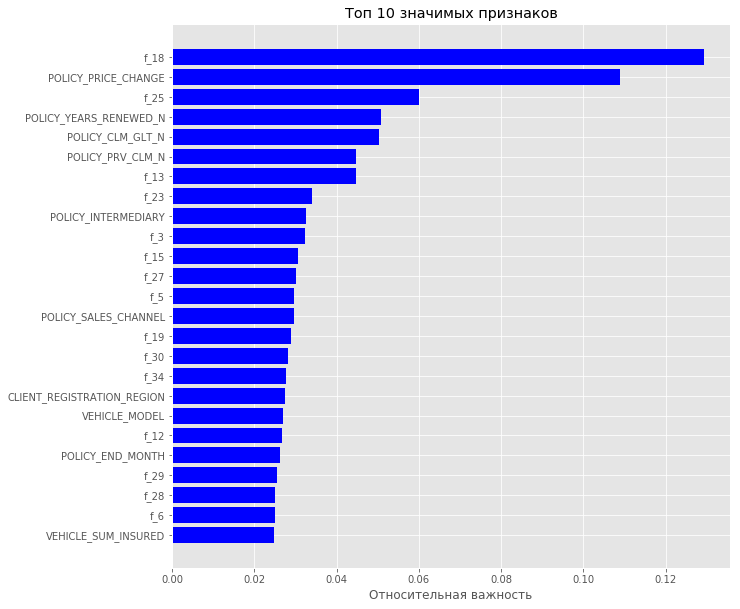

In [164]:
features = top_feature
importances = rfc.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,10))
plt.title('Топ 10 значимых признаков')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Относительная важность')
plt.show()

#### Из диаграммы видим, что наиболее важные признаки (по убыванию): 

    POLICY_PRICE_CHANGE - как поменялась премия при пролонгации
    POLICY_YEARS_RENEWED_N - количество лет пролонгации полиса
    POLICY_CLM_GLT_N - кол-во убытков, где клиент виновен в ДТП по данному полису
    POLICY_PRV_CLM_N - кол-во убытков всего по предыдущему (если есть) полису (клиент пролонгируется второй и более раз)

## Сохранение тестовых результатов

Сделаем предсказание для тестовой выборки.

In [187]:
Y_test_predict = clf.predict(X_test_tree)

Прогнозные значения сохраянем в файл.

In [219]:
rez_table = pd.DataFrame()
rez_table['POLICY_ID'] = data['POLICY_ID'][test_index]
rez_table['POLICY_IS_RENEWED'] = Y_test_predict
rez_table['POLICY_IS_RENEWED_PROBABILITY'] = result

PATH_TO_DATA_SAVE = 'D:\Задача 1\Pavlov_Rezult.csv'
rez_table.to_csv(PATH_TO_DATA_SAVE, header=1, sep=',', 
          quotechar='"', encoding='utf-8', index=False)

# 5. Дальнейшие планы по улучшению точности прогноза
---

#### 1) применить XGBoost
#### 2) обогащение данных
#### 3) слияние моделей
---